# Faster R-CNN:Inference
## Load Configurations

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from config.config import Config
from src.data_generator import VOCData
from src.model import unparameterize_box, xyctrwh_to_yxyx, yxyx_to_xyctrwh

# increase image resolution for jupyter notebook
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100


# load config
config = Config()
config.BATCH_SIZE = 8

Configuration is loaded: 
{'LR': 0.0001, 'DECAY': 0.0005, 'BATCH_SIZE': 8, 'EPOCH': 10000, 'DETECTION_NMS_IOU': 0.5, 'DETECTION_NMS_MAX_NUM': 100, 'INPUT_SHAPE': [600, 1000, 3], 'NUM_CLASS': 20, 'MAX_GT_INSTANCE': 50, 'BACKBONE': None, 'FEATURE_SHAPE': [37, 62], 'ANCHOR_NUM': 9, 'ANCHOR_SCALES': [128, 256, 512], 'ANCHOR_RATIOS': [0.5, 1.0, 2.0], 'FEATRUE_STRIDE': 16, 'ANCHOR_STRIDE': 1, 'RPN_POS_IOU_THOLD': 0.7, 'RPN_NEG_IOU_THOLD': 0.3, 'RPN_TOTAL_SAMPLE_NUM': 256, 'RPN_POS_SAMPLE_RATIO': 0.5, 'RPN_LAMBDA': 10.0, 'RPN_NMS_NUM': 2000, 'RPN_NMS_IOU': 0.7, 'RCNN_ROI_POOL_SIZE': 7, 'RCNN_POS_IOU_THOLD': 0.5, 'RCNN_NEG_IOU_THOLD': 0.1, 'RCNN_TOTAL_SAMPLE_NUM': 64, 'RCNN_POS_SAMPLE_RATIO': 0.25, 'RCNN_LAMDA': 1.0}


## Load Datasets
> Note: Because training on the entire data set has not been done yet, only the `DEBUG` mode is provided. 

In [2]:
# load dataset
test_data_dir = 'dataset/VOC2007/trainval/VOCdevkit/VOC2007'
test_dataset = VOCData(test_data_dir,
                        config.INPUT_SHAPE,
                        batch_size=config.BATCH_SIZE,
                        max_gt_instance=config.MAX_GT_INSTANCE,
                        debug=True)

Load from: dataset/VOC2007/trainval/VOCdevkit/VOC2007
DEBUD MODE: True
Batch size: 8
Images: 8
Classes: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']



## Load Trained Faster R-CNN
> Note: This model is onverfitted with only 8 images.

In [3]:
# saved model dir
model_dir = 'model/20210819-170020-debug'
model = tf.keras.models.load_model(model_dir)
model.summary()


{}

Model: "faster_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 1000, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 600, 1000, 64 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 600, 1000, 64 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 300, 500, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________

## Visualize Faster-R-CNN Results
### 1. Chose the data point index in range [0,7].

In [4]:
# data point
idx = 5
print("Viusalize {} th image results.".format(idx))

Viusalize 5 th image results.


### 2. Get Network Ouputs
1. `rcnn_cls_output`: Class probability of predicted bounding boxes. 
2. `rcnn_reg_output`: Predicted parameterized bounding boxes. It should be unparamterized by `roi_boxes`.
3. `roi_boxes`: Non-maximum suppresseed rigion proposals from RPN.
4. `valid_num`: Number of valid `roi_boxes`.


In [5]:
# get result from the network
img_batch, (gt_cls_ids_batch, gt_boxes_batch, num_gt_instance_batch) = test_dataset[0]

# get idt'th data
img_batch = img_batch[idx:idx+1]
gt_cls_ids_batch = gt_cls_ids_batch[idx:idx+1]
gt_boxes_batch = gt_boxes_batch[idx:idx+1]
num_gt_instance_batch = num_gt_instance_batch[idx:idx+1]

# get outputs
outputs = model(img_batch, training=False)

# unpack outputs
rcnn_cls_output = outputs[2].numpy()  # [N, 21]
rcnn_reg_output = outputs[3].numpy()  # [N, 20*4]
roi_boxes = outputs[4].numpy()  # [N, 4]
valid_num = outputs[5][0].numpy()  # []

print("Sahpe of rcnn_cls_output: ", rcnn_cls_output.shape)
print("Shape of rcnn_reg_output: ", rcnn_reg_output.shape)
print("Shape of roi_boxes: ", roi_boxes.shape)
print("Number of valid boxes: ", valid_num)


Sahpe of rcnn_cls_output:  (2000, 21)
Shape of rcnn_reg_output:  (2000, 20, 4)
Shape of roi_boxes:  (2000, 4)
Number of valid boxes:  2000


### 3. Visualize Results 
>Note: If the model does not detect objects, it will show ground-truth image only.

Number of positive boxes:  10
[5th image/13th class id] Initial positive boxes: 7
[5th image/13th class id] After nms boxes: 2
[5th image/15th class id] Initial positive boxes: 3
[5th image/15th class id] After nms boxes: 1
[NMS Config] IoU Threshold: 0.5
[NMS Config] Max Outputs: 100


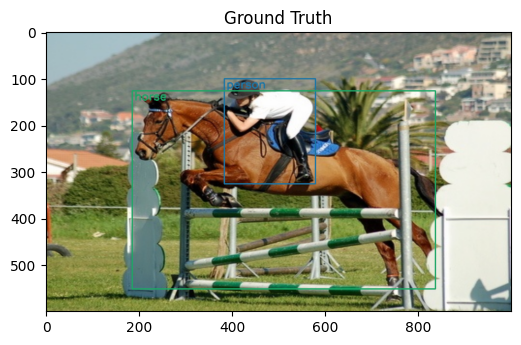

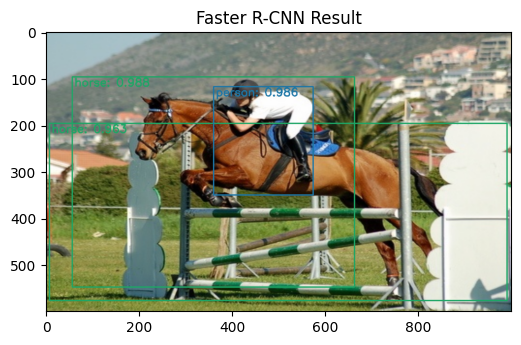

In [6]:

# get valid 
rcnn_cls_output = rcnn_cls_output[:valid_num]  # [valid_num, 21]
rcnn_reg_output = rcnn_reg_output[:valid_num]  # [valid_num, 20*4]
rcnn_reg_output = np.reshape(rcnn_reg_output, (valid_num, config.NUM_CLASS, 4))
roi_boxes = roi_boxes[:valid_num]

# get class id and scores
cls_id = np.argmax(rcnn_cls_output, axis=-1)
cls_score = np.max(rcnn_cls_output, axis=-1)
total_positive_boxes = np.count_nonzero(cls_id)
print("Number of positive boxes: ", total_positive_boxes)

# per class non maximum surpresssion
if total_positive_boxes != 0:
    selected_boxes = list()
    selected_cls_id = list()
    selected_score = list()
    for i in range(1, config.NUM_CLASS + 1):
        if np.count_nonzero(i==cls_id) == 0:
            continue
        
        # get i th class boxes
        param_boxes_i = rcnn_reg_output[cls_id == i, i-1, :]
        roi_boxes_i = roi_boxes[cls_id == i]
        cls_score_i = cls_score[cls_id == i]
        
        # unparamterize boxes
        boxes_i = unparameterize_box(param_boxes_i, yxyx_to_xyctrwh(roi_boxes_i))
        boxes_i = xyctrwh_to_yxyx(boxes_i)
        
        # non maximum surpression
        selected_boxes_indicies_i = tf.image.non_max_suppression(
            boxes_i,
            cls_score_i,
            max_output_size=config.DETECTION_NMS_MAX_NUM,
            iou_threshold=config.DETECTION_NMS_IOU)
        selected_boxes_i = tf.gather(boxes_i, selected_boxes_indicies_i)
        selected_score_i = tf.gather(cls_score_i, selected_boxes_indicies_i)

        # clip boxes with image bounday
        selected_boxes_i = tf.clip_by_value(
            selected_boxes_i,
            clip_value_min=[[0, 0, 0, 0]],
            clip_value_max=[[config.INPUT_SHAPE[0]-1, config.INPUT_SHAPE[1]-1, config.INPUT_SHAPE[0]-1, config.INPUT_SHAPE[1]-1]],
        ) 
        
        # append to list
        selected_boxes.append(np.array(selected_boxes_i))
        selected_cls_id.append(np.zeros(len(selected_boxes_i), dtype='int32') + i)
        selected_score.append(np.array(selected_score_i))
        
        print("[{}th image/{}th class id] Initial positive boxes: {}".format(idx, i, np.count_nonzero(cls_id==i)))
        print("[{}th image/{}th class id] After nms boxes: {}".format(idx, i, len(selected_boxes_i)))

    # print post-process configurations
    print("[NMS Config] IoU Threshold: {}".format(config.DETECTION_NMS_IOU))
    print("[NMS Config] Max Outputs: {}".format(config.DETECTION_NMS_MAX_NUM))

    # list to numpy
    selected_boxes = np.concatenate(selected_boxes)
    selected_cls_id = np.concatenate(selected_cls_id)
    selected_score = np.concatenate(selected_score)
    
    image = img_batch[0]
    num_gt_instance = num_gt_instance_batch[0]
    gt_cls_id = gt_cls_ids_batch[0][:num_gt_instance]
    gt_boxes = gt_boxes_batch[0][:num_gt_instance]

    gt_labeled_image = test_dataset.draw_label_img(image, gt_cls_id, gt_boxes)
    plt.title('Ground Truth')
    plt.imshow(gt_labeled_image)
    plt.show()

    output_labeled_image = test_dataset.draw_label_img(image, selected_cls_id, selected_boxes, selected_score)
    plt.title('Faster R-CNN Result')
    plt.imshow(output_labeled_image)
    plt.show()

else:
    print("0 boxes are predicted! Only show the ground-truth image")
    image = img_batch[0]
    num_gt_instance = num_gt_instance_batch[0]
    gt_cls_id = gt_cls_ids_batch[0][:num_gt_instance]
    gt_boxes = gt_boxes_batch[0][:num_gt_instance]

    gt_labeled_image = test_dataset.draw_label_img(image, gt_cls_id, gt_boxes)
    plt.title('Ground Truth')
    plt.imshow(gt_labeled_image)
    plt.show()
